In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Data Loading 

In [41]:
train_dir = r'/net/ens/DeepLearning/DLCV2024/MexCulture142/images_train'
val_dir = r'/net/ens/DeepLearning/DLCV2024/MexCulture142/images_val'

# Defining the classes based on filename prefixes
CLASS_NAMES = ['Prehispanic', 'Colonial', 'Modern']

# Function to extract class label from filename
def get_class_name_from_filename(filename):
    if 'Prehispanic' in filename:
        return 0  # Class 0 for Prehispanic
    elif 'Colonial' in filename:
        return 1  # Class 1 for Colonial
    elif 'Modern' in filename:
        return 2  # Class 2 for Modern
    else:
        raise ValueError(f"Unknown class label in filename: {filename}")

# Function to load images and labels from a directory
def load_images_and_labels(directory):
    image_list = []
    label_list = []
    
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image = Image.open(file_path)
            image = image.resize((224, 224))  # Resize image to 224x224
            image = np.array(image)  # No manual normalization needed
            label = get_class_name_from_filename(filename)  # Extract label
            image_list.append(image)
            label_list.append(label)
    
    return np.array(image_list), np.array(label_list)

# Load training and validation images and labels
train_images, train_labels = load_images_and_labels(train_dir)
val_images, val_labels = load_images_and_labels(val_dir)

# Convert labels to one-hot encoding   (check report why we are doing this)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(CLASS_NAMES))
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=len(CLASS_NAMES))

print(f"Found {len(train_images)} images belonging to {len(CLASS_NAMES)} classes for training.")
print(f"Found {len(val_images)} images belonging to {len(CLASS_NAMES)} classes for validation.")


Found 236 images belonging to 3 classes for training.
Found 48 images belonging to 3 classes for validation.


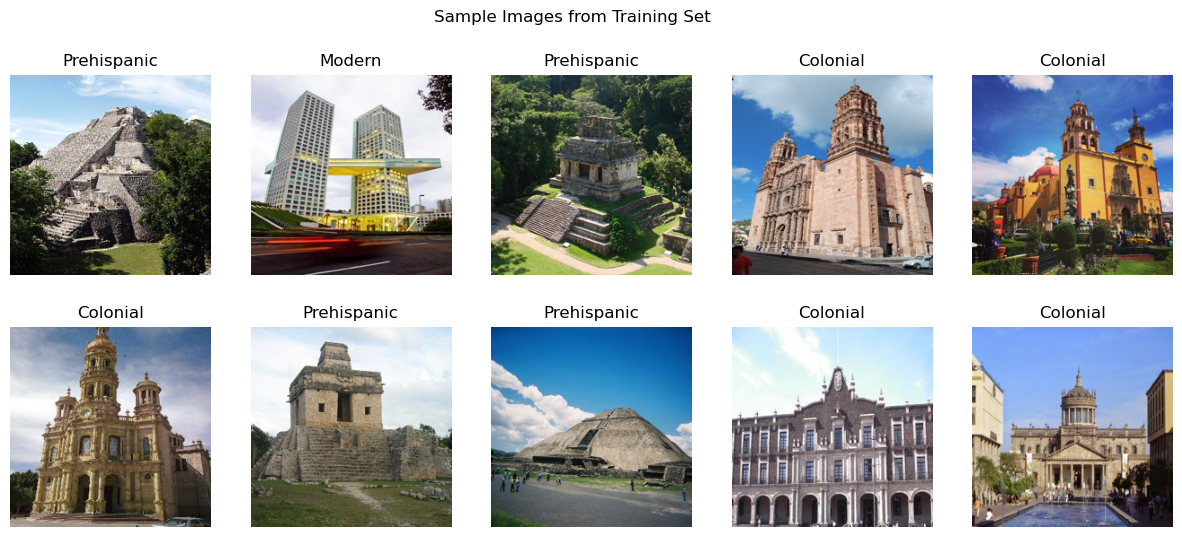

In [42]:
# Display a few random images from training data
def show_random_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(15, 6))
    sample_indices = random.sample(range(len(images)), min(num_images, len(images)))
    for i, idx in enumerate(sample_indices):
        img = images[idx]
        label = np.argmax(labels[idx])  # Get class label from one-hot encoded labels
        plt.subplot(2, 5, i+1)
        plt.imshow(img.astype('uint8'))  # Convert to uint8 for display
        plt.title(f"{class_names[label]}")
        plt.axis('off')
    plt.suptitle("Sample Images from Training Set")
    plt.show()

# Display random images from training set
show_random_images(train_images, train_labels, CLASS_NAMES)

# Data augmentation and preprocessing

In [43]:

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators using Numpy arrays
train_generator = train_datagen.flow(
    train_images,
    train_labels,
    batch_size=8,   #16, 32
    shuffle=True
)

validation_generator = val_datagen.flow(
    val_images,
    val_labels,
    batch_size=8,   #16, 32
    shuffle=False
)

# Simulate class_indices from CLASS_NAMES
class_indices = {class_name: idx for idx, class_name in enumerate(CLASS_NAMES)}

# Display the mapping
print("Class Indices:", class_indices)


Class Indices: {'Prehispanic': 0, 'Colonial': 1, 'Modern': 2}


## Model Architecture: ResNet50 with Custom Layers

In [44]:
# ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Here i am Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

## Model Compilation and Training


In [25]:
# Define optimizer and compile the model
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.2,
    min_lr=1e-7
)

# Train the model
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# # Check if early stopping occurred
# trained_epochs = len(history.history['loss'])  # The actual number of epochs trained
# if trained_epochs < epochs:
#     print(f"Early stopping was triggered after {trained_epochs} epochs out of {epochs}.")
# else:
#     print(f"Training completed the full {epochs} epochs without early stopping.")



Epoch 1/30
30/30 [==============================] - 8s 177ms/step - loss: 0.5366 - accuracy: 0.9746 - val_loss: 4.5143 - val_accuracy: 0.8750 - lr: 0.0100
Epoch 2/30
30/30 [==============================] - 4s 133ms/step - loss: 0.1351 - accuracy: 0.9746 - val_loss: 2.9170 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 3/30
30/30 [==============================] - 4s 130ms/step - loss: 0.0742 - accuracy: 0.9958 - val_loss: 5.1111 - val_accuracy: 0.8750 - lr: 0.0100
Epoch 4/30
30/30 [==============================] - 4s 128ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 7.7572 - val_accuracy: 0.7917 - lr: 0.0100
Epoch 5/30
30/30 [==============================] - 4s 128ms/step - loss: 0.1727 - accuracy: 0.9915 - val_loss: 5.9450 - val_accuracy: 0.8333 - lr: 0.0100
Epoch 6/30
30/30 [==============================] - 4s 131ms/step - loss: 0.0367 - accuracy: 0.9915 - val_loss: 1.9455 - val_accuracy: 0.8958 - lr: 0.0020
Epoch 7/30
30/30 [==============================] - 4s 129ms/step - lo

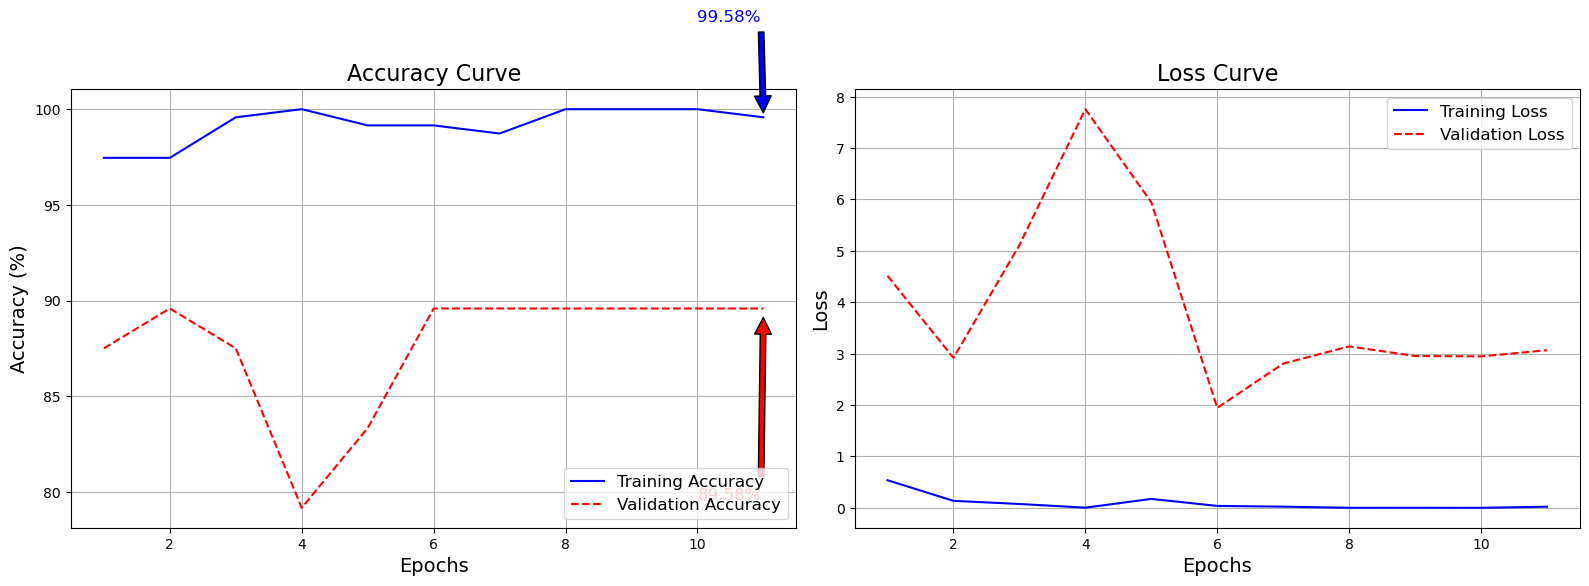

In [26]:
# Plot accuracy and loss curves
train_accuracy = [acc * 100 for acc in history.history['accuracy']]
val_accuracy = [acc * 100 for acc in history.history['val_accuracy']]
epochs_range = range(1, len(train_accuracy) + 1)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy plot
axs[0].plot(epochs_range, train_accuracy, 'b-', label='Training Accuracy')
axs[0].plot(epochs_range, val_accuracy, 'r--', label='Validation Accuracy')
axs[0].set_title('Accuracy Curve', fontsize=16)
axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Accuracy (%)', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# Annotate final accuracy values
final_train_acc = train_accuracy[-1]
final_val_acc = val_accuracy[-1]
axs[0].annotate(f'{final_train_acc:.2f}%', xy=(epochs_range[-1], final_train_acc),
                xytext=(epochs_range[-1]-1, final_train_acc+5),
                arrowprops=dict(facecolor='blue', shrink=0.05),
                fontsize=12, color='blue')
axs[0].annotate(f'{final_val_acc:.2f}%', xy=(epochs_range[-1], final_val_acc),
                xytext=(epochs_range[-1]-1, final_val_acc-10),
                arrowprops=dict(facecolor='red', shrink=0.05),
                fontsize=12, color='red')

# Loss plot
axs[1].plot(epochs_range, history.history['loss'], 'b-', label='Training Loss')
axs[1].plot(epochs_range, history.history['val_loss'], 'r--', label='Validation Loss')
axs[1].set_title('Loss Curve', fontsize=16)
axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].grid(True)

# Save and show plot
plt.tight_layout()
plt.savefig('training_validation_plots.png')
plt.show()



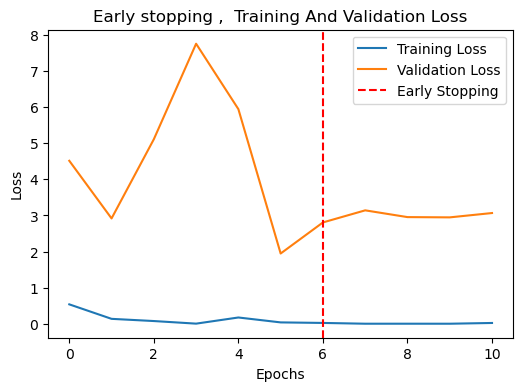

In [39]:
# Plot early stopping and Losses
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(len(history.history['loss']) - early_stopping.patience, color='r', linestyle='--', label='Early Stopping')
plt.title('Early stopping ,  Training And Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 [==============================] - 1s 103ms/step


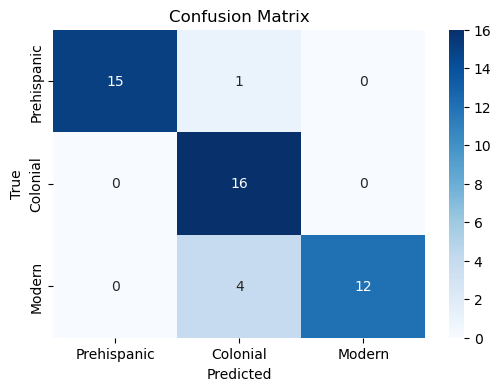

              precision    recall  f1-score   support

 Prehispanic       1.00      0.94      0.97        16
    Colonial       0.76      1.00      0.86        16
      Modern       1.00      0.75      0.86        16

    accuracy                           0.90        48
   macro avg       0.92      0.90      0.90        48
weighted avg       0.92      0.90      0.90        48



In [27]:
# Evaluate and plot confusion matrix
validation_generator.reset()
Y_true = np.argmax(val_labels, axis=1)
Y_pred_prob = model.predict(validation_generator)
Y_pred = np.argmax(Y_pred_prob, axis=1)

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()



# Classification report
report = classification_report(Y_true, Y_pred, target_names=CLASS_NAMES)
print(report)


## printing outptut which are misclassified 

6/6 [==============================] - 1s 99ms/step


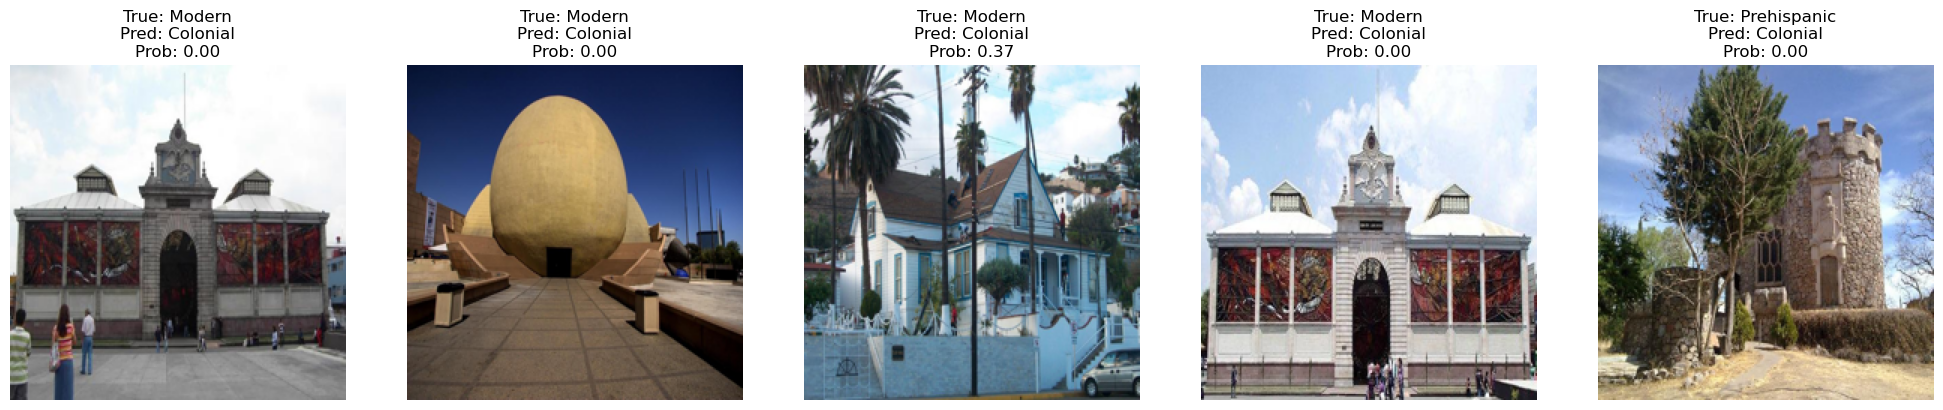

In [30]:
# first Reset the validation generator to ensure fresh predictions and Get the true labels from the validation set
validation_generator.reset()
Y_true = np.argmax(val_labels, axis=1)
Y_pred_prob = model.predict(validation_generator)

# Convert predicted probabilities to predicted class indices
Y_pred = np.argmax(Y_pred_prob, axis=1)
misclassified_indices = np.where(Y_pred != Y_true)[0] # Identify the misclassified indices

# here Get the probability of the true class for each misclassified image
true_class_prob = [Y_pred_prob[i][Y_true[i]] for i in misclassified_indices]
sorted_indices = np.argsort(true_class_prob) # sorting by lowest confidence
filenames = os.listdir(val_dir)
worst_indices = misclassified_indices[sorted_indices[:10]]

num_images = len(worst_indices)
num_cols = 5 
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows

plt.figure(figsize=(20, num_rows * 4))  # Adjust plot size 

for i, idx in enumerate(worst_indices):

    filepath = os.path.join(val_dir, filenames[idx]) # Get the file path of the misclassified image
    
    # Open and resize the image for consistent display
    img = Image.open(filepath).resize((224, 224))
    
    # Plot the image
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    
    # Get true and predicted class labels
    true_label = CLASS_NAMES[Y_true[idx]]
    predicted_label = CLASS_NAMES[Y_pred[idx]]
    probability = true_class_prob[i]
    
    plt.title(f"True: {true_label}\nPred: {predicted_label}\nProb: {probability:.2f}")
    plt.axis('off')  # here i am Hiding the axis for cleaner display

plt.tight_layout() # Adjust layout for better spacing
plt.show()


In [31]:
 #Add this line after identifying misclassified indices
print(f"Total misclassified images: {len(misclassified_indices)}")

Total misclassified images: 5


In [ ]:
## priting outptut which are correctly classified 

6/6 [==============================] - 1s 99ms/step


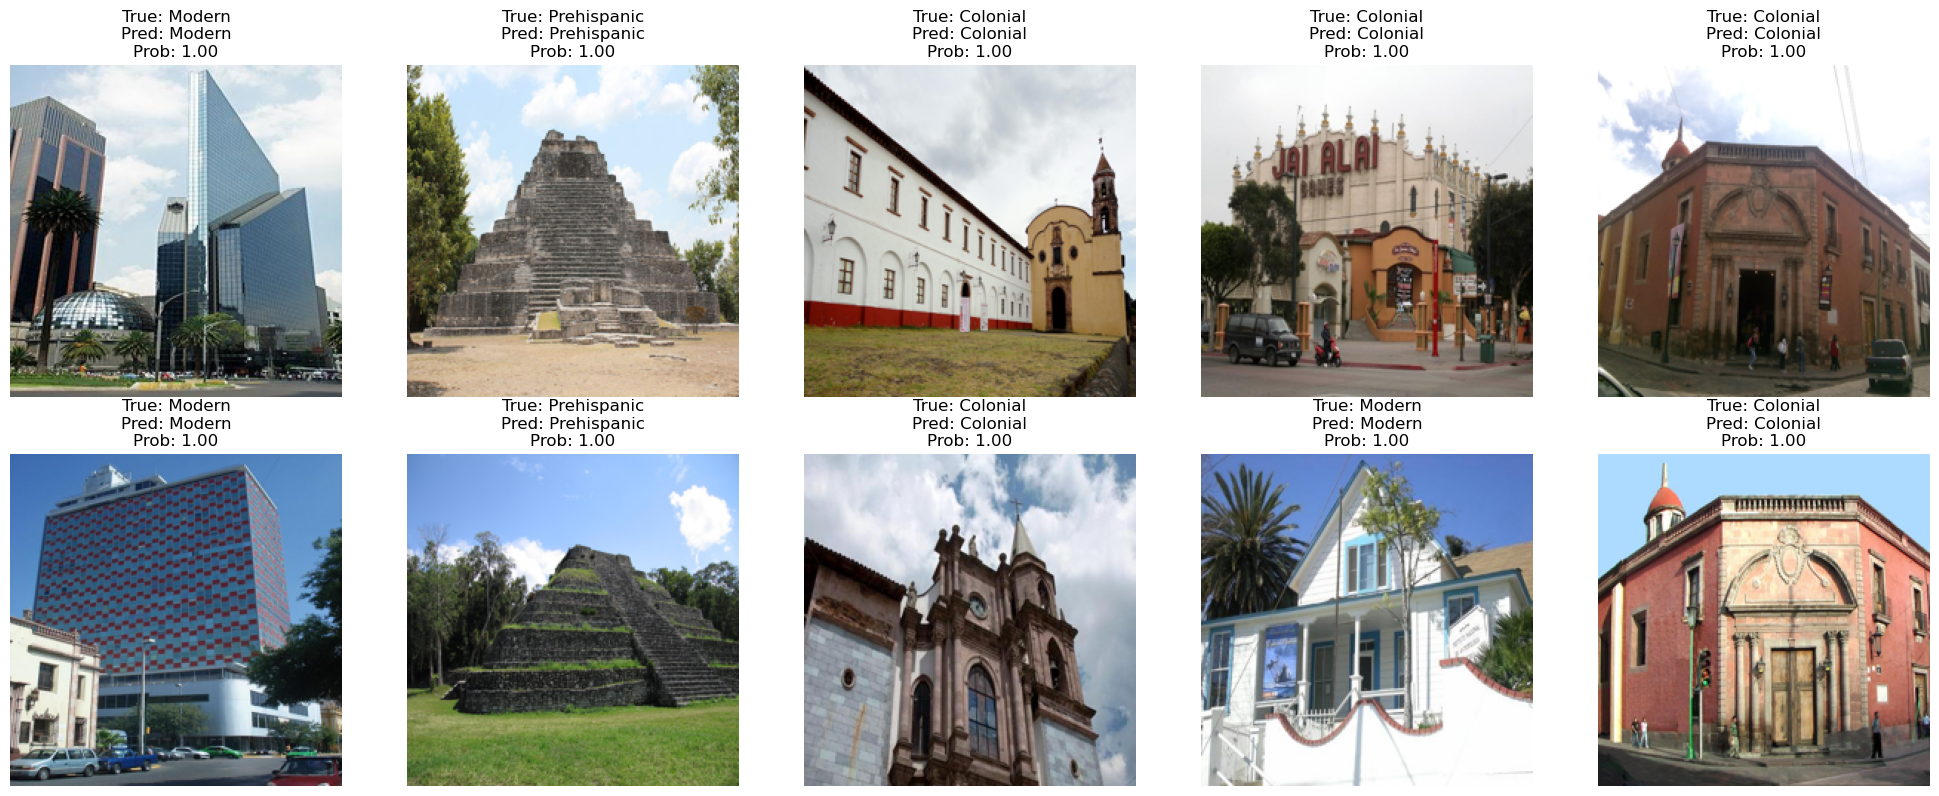

In [38]:
validation_generator.reset()
Y_true = np.argmax(val_labels, axis=1)
Y_pred_prob = model.predict(validation_generator)

# Convert predicted probabilities to predicted class indices
Y_pred = np.argmax(Y_pred_prob, axis=1)
correct_indices = np.where(Y_pred == Y_true)[0]

# Randomly sample 10 correctly classified images
random_correct_indices = np.random.choice(correct_indices, size=min(10, len(correct_indices)), replace=False)
filenames = os.listdir(val_dir)

# Plot randomly selected correctly classified images
num_images = len(random_correct_indices)
num_cols = 5 
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows

plt.figure(figsize=(20, num_rows * 4))  # Adjust plot size

for i, idx in enumerate(random_correct_indices):
    filepath = os.path.join(val_dir, filenames[idx])
    
    img = Image.open(filepath).resize((224, 224))
    
    # Plot the image
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    
    true_label = CLASS_NAMES[Y_true[idx]]
    predicted_label = CLASS_NAMES[Y_pred[idx]]
    probability = Y_pred_prob[idx][Y_pred[idx]]  # Confidence in the predicted class
    
    plt.title(f"True: {true_label}\nPred: {predicted_label}\nProb: {probability:.2f}")
    plt.axis('off')  # Hide axis for cleaner display
    
plt.tight_layout()
plt.show()
